# VGGish Speech Commands: Complete Pipeline

This comprehensive notebook combines the entire audio classification pipeline for the Speech Commands dataset using VGGish. It demonstrates three different approaches to leveraging pre-trained deep learning models for audio classification.

## Pipeline Overview

| Step | Description | Section |
|------|-------------|---------|
| **Step 1** | Generate Spectrograms | Convert 105,835 WAV files to 96x64 log-mel spectrograms |
| **Step 2** | Generate Embeddings | Pass spectrograms through VGGish to produce 128-dim vectors |
| **Step 3a** | Feature Extraction | Train XGBoost on embeddings (~18.4% accuracy) |
| **Step 3b** | Transfer Learning | Frozen VGGish + trainable classifier (~30.4% accuracy) |
| **Step 3c** | Warm Start | Fine-tune entire network (~96.6% accuracy) |

## Key Results Summary

| Approach | VGGish Weights | Classifier | Accuracy | Training Time |
|----------|---------------|------------|----------|---------------|
| Feature Extraction | Frozen | XGBoost | ~18.4% | 3 min (CPU) |
| Transfer Learning | Frozen | Neural Network | ~30.4% | 28 min (GPU) |
| **Warm Start** | **Fine-tuned** | **Neural Network** | **~96.6%** | 1h 20min (GPU) |

**Main Insight:** The dramatic accuracy improvement from transfer learning (30%) to warm start (97%) demonstrates that for domain-specific tasks, fine-tuning the entire network is often necessary. Frozen features from a general-purpose model may not capture the task-specific patterns needed for high accuracy.

---

## Table of Contents

1. [Step 1: Generate Spectrograms](#step-1-generate-spectrograms) - Preprocessing audio files
2. [Step 2: Generate Embeddings](#step-2-generate-embeddings) - Feature extraction with VGGish
3. [Approach 1: Feature Extraction (XGBoost)](#approach-1-feature-extraction-xgboost) - Using embeddings as fixed features
4. [Approach 2: Transfer Learning](#approach-2-transfer-learning) - Frozen VGGish backbone
5. [Approach 3: Warm Start](#approach-3-warm-start) - Fine-tuning the entire network

---

---

<a id="step-1-generate-spectrograms"></a>
# Step 1. Generate Spectrograms

---

# VGGish - Speech Commands - Generate Spectrograms

**Pipeline Step 1: Audio Preprocessing**

This is the first step in the audio classification pipeline. It processes all ~105,000 audio files from the Speech Commands dataset and converts each one into a log-mel spectrogram suitable for the VGGish network.

**Pipeline overview:**
1. **Generate spectrograms** (this notebook) -- Convert WAV files to 96x64 spectrograms
2. Generate embeddings -- Pass spectrograms through VGGish to produce 128-dim vectors
3. Train classifier -- Use embeddings or spectrograms to classify spoken words

**What this notebook does:**
- Walks the Speech Commands dataset directory to catalog all WAV files with their labels
- Converts each audio file to a VGGish-format spectrogram (96 time frames x 64 mel bands)
- Flags invalid entries (files that don't produce exactly one 96x64 spectrogram)
- Saves the spectrogram array and metadata to disk for use in subsequent notebooks

## Setup

Import the VGGish library and its spectrogram generation utilities. The VGGish pipeline expects audio at 16 kHz and produces spectrograms with a window hop of 0.96 seconds, meaning each ~1-second audio clip yields a single 96x64 spectrogram frame.

In [ ]:
import sys
sys.path.append("/home/ubuntu/odsc/vggish/lib/models/research/audioset/vggish")

In [ ]:
import pandas as pd
import os

In [ ]:
import vggish_params


In [ ]:
vggish_params.EXAMPLE_HOP_SECONDS, vggish_params.EXAMPLE_WINDOW_SECONDS

(0.96, 0.96)

In [ ]:
import numpy as np
import six
import soundfile
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  0


In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

## Building the Dataset Catalog

Walk the Speech Commands directory tree to build a DataFrame of all WAV files. Each subdirectory name is the spoken word label (e.g., "zero", "yes", "stop"). The dataset contains 105,835 files across 35 word categories plus a `_background_noise_` directory (6 files) which is included here but later filtered out.

The class distribution is imbalanced: the 20 "core" words have ~3,700-4,000 samples each, while the 15 "auxiliary" words have ~1,400-2,100 samples each.

In [ ]:

import vggish_input
import vggish_postprocess
import vggish_slim

pca_params = '/home/ubuntu/odsc/vggish/lib/vggish_pca_params.npz'
ckpt = '/home/ubuntu/odsc/vggish/lib/vggish_model.ckpt'

In [ ]:
wav_files = {
    'file_name' : [],
    'label': []
}

rootDir = '/home/ubuntu/audio/speech_commands'
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        if fname.endswith('.wav'):
            wav_files['label'].append(os.path.basename(dirName))
            wav_files['file_name'].append(os.path.join(dirName, fname))

df = pd.DataFrame(data=wav_files)

In [ ]:
df.head()

,file_name,label
0,/home/ubuntu/audio/speech_commands/zero/8a90cf...,zero
1,/home/ubuntu/audio/speech_commands/zero/173ae7...,zero
2,/home/ubuntu/audio/speech_commands/zero/eb76bc...,zero
3,/home/ubuntu/audio/speech_commands/zero/978240...,zero
4,/home/ubuntu/audio/speech_commands/zero/246328...,zero


## Verifying Single-File Spectrogram Generation

Before processing the full dataset, we verify that a single WAV file produces the expected 96x64 spectrogram. The `wavfile_to_examples()` function returns a batch of spectrograms -- for 1-second clips, this should be exactly one spectrogram with shape `(1, 96, 64)`.

In [ ]:
df.shape

(105835, 2)

In [ ]:
df['label'].value_counts()

five                  4052
zero                  4052
yes                   4044
seven                 3998
no                    3941
nine                  3934
down                  3917
one                   3890
go                    3880
two                   3880
stop                  3872
six                   3860
on                    3845
left                  3801
eight                 3787
right                 3778
off                   3745
four                  3728
three                 3727
up                    3723
dog                   2128
wow                   2123
house                 2113
marvin                2100
bird                  2064
happy                 2054
cat                   2031
sheila                2022
bed                   2014
tree                  1759
backward              1664
visual                1592
follow                1579
learn                 1575
forward               1557
_background_noise_       6
Name: label, dtype: int64

## Batch Spectrogram Generation

Process all 105,835 audio files. For each file:
1. Generate the VGGish spectrogram using `wavfile_to_examples()`
2. If the result has exactly 1 frame (shape `(1, 96, 64)`), store it and mark as valid
3. If the result has 0 or >1 frames (due to audio being too short or too long), mark as invalid

Some files produce invalid spectrograms -- typically the `_background_noise_` files which are longer than 1 second. These will be filtered out before training.

The spectrograms are stored in a pre-allocated NumPy array of shape `(105835, 96, 64)`. Progress is printed every 1,000 files.

In [ ]:
fname = df['file_name'][0]
fname

'/home/ubuntu/audio/speech_commands/zero/8a90cf67_nohash_0.wav'

## Saving Results

Save the DataFrame (with file paths, labels, and validity flags) to CSV and the spectrogram array to a binary file. These outputs are used by the subsequent notebooks:
- `wavfile_df.csv` -- metadata for all 105,835 audio files
- `wavfile_spec.dat` -- raw binary dump of the spectrogram NumPy array (105,835 x 96 x 64 float64 values)

In [ ]:
ex = vggish_input.wavfile_to_examples(fname)

In [ ]:
ex.shape

(1, 96, 64)

In [ ]:
audio_data = np.empty((df.shape[0], 96, 64))

In [ ]:
for ind, row in df.iterrows():
    data = vggish_input.wavfile_to_examples(row.file_name)
    if data.shape[0] != 1:
        df.loc[ind, 'valid'] = False
        continue
    audio_data[ind, :, :] = data
    df.loc[ind, 'valid'] = True
    if ind % 1000==0:
        print(ind)

0
1000
3000
... [10 progress updates omitted] ...
103000
104000
105000

In [ ]:
df.to_csv('wavfile_df.csv')

In [ ]:
with open('wavfile_spec.dat', 'wb') as f:
    audio_data.tofile(f)

---

<a id="step-2-generate-embeddings"></a>
# Step 2. Generate Embeddings

---

# VGGish - Speech Commands - Embedding Generation

**Pipeline Step 2: Feature Extraction with VGGish**

This notebook takes the spectrograms generated in the previous step and passes each one through the pre-trained VGGish network to produce a 128-dimensional embedding vector. These embeddings serve as compact, semantically meaningful feature representations of each audio clip.

**Why embeddings?** Rather than training a classifier directly on the raw 96x64 spectrograms (6,144 values), we can use VGGish's pre-trained knowledge to compress each spectrogram into a 128-dimensional vector. This is the "feature extraction" approach to transfer learning -- using a pre-trained network as a fixed feature extractor.

**Pipeline context:**
1. Generate spectrograms (previous notebook)
2. **Generate embeddings** (this notebook) -- Pass spectrograms through VGGish
3. Train classifier (next notebook) -- Use embeddings as input features

## Setup

Import TensorFlow and the VGGish library. This notebook was run on an AWS instance with 16 GPUs (p3.16xlarge), though the embedding generation loop uses a single GPU session.

In [ ]:
import sys
sys.path.append("/home/ubuntu/odsc/vggish/lib/models/research/audioset/vggish")

In [ ]:
import pandas as pd
import os

In [ ]:
import vggish_params


In [ ]:
vggish_params.EXAMPLE_HOP_SECONDS, vggish_params.EXAMPLE_WINDOW_SECONDS

(0.96, 0.96)

In [ ]:
import numpy as np
import six
import soundfile
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  16


In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0',
 '/device:GPU:1',
 '/device:GPU:2',
 '/device:GPU:3',
 '/device:GPU:4',
 '/device:GPU:5',
 '/device:GPU:6',
 '/device:GPU:7',
 '/device:GPU:8',
 '/device:GPU:9',
 '/device:GPU:10',
 '/device:GPU:11',
 '/device:GPU:12',
 '/device:GPU:13',
 '/device:GPU:14',
 '/device:GPU:15']

In [ ]:

import vggish_input
import vggish_postprocess
import vggish_slim

pca_params = '/home/ubuntu/odsc/vggish/lib/vggish_pca_params.npz'
ckpt = '/home/ubuntu/odsc/vggish/lib/vggish_model.ckpt'

## Loading Pre-Generated Spectrograms

Load the spectrogram data saved in the previous notebook. The binary file contains the raw float64 values of all 105,835 spectrograms, which we reshape into `(105835, 96, 64)` -- one 96x64 spectrogram per audio file.

In [ ]:
pwd

'/home/ubuntu/odsc/vggish'

In [ ]:
df = pd.read_csv('wavfile_df.csv', index_col=0)
df.shape

(105835, 3)

In [ ]:
with open('wavfile_spec.dat', 'rb') as f:
    audio_data = np.fromfile(f)

In [ ]:
audio_array = audio_data.reshape((-1, 96, 64))

## Defining the VGGish Inference Pipeline

Define the VGGish model in inference mode (`training=False`) and load the pre-trained checkpoint. The model takes spectrograms as input (`features_tensor`) and produces 128-dim embeddings as output (`embedding_tensor`). No weights are updated during this step -- VGGish acts as a fixed feature extractor.

## Generating Embeddings in Batches

Processing all 105,835 spectrograms at once would exceed GPU memory, so we split them into 20 batches (~5,290 spectrograms each). Each batch is fed through VGGish, and the resulting embeddings are stored in a pre-allocated output array.

The output is a matrix of shape `(105835, 128)` -- one 128-dimensional embedding vector per audio file.

In [ ]:
audio_array.shape

(105835, 96, 64)

In [ ]:
df.shape

(105835, 3)

### Examining the Raw Embedding

Each embedding is a 128-dimensional vector of non-negative floating-point values (due to the ReLU activation). Many values are zero, while non-zero values capture different learned audio features. The sparse, non-negative structure is typical of deep network activations.

### Post-Processing (Optional)

The VGGish authors provide a post-processing step that applies PCA, whitening, and quantization to convert the 128-dim float32 embeddings into 128-dim uint8 vectors. This was designed for compatibility with the YouTube-8M pipeline. Below, we demonstrate this step but use the **raw float32 embeddings** for our downstream classification tasks.

In [ ]:
def define_and_init_vggish():
    # Define the model in inference mode, load the checkpoint, and
    # locate input and output tensors.
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, ckpt)
    features_tensor = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(
        vggish_params.OUTPUT_TENSOR_NAME)

    return features_tensor, embedding_tensor

## Saving Embeddings

Save the raw embeddings both as a binary file (`wavfile_embed.dat`) and as additional columns in the metadata DataFrame (`wavfile_embed.csv`). The CSV file contains the original metadata (file_name, label, valid) plus 128 embedding columns (e0 through e127), making it convenient for downstream analysis and modeling.

In [ ]:
batches = np.array_split(np.arange(audio_array.shape[0]), 20)

In [ ]:
with tf.Graph().as_default(), tf.Session() as sess:
    features_tensor, embedding_tensor = define_and_init_vggish()
    
    for b in batches:
        [embedding_output[b]] = sess.run([embedding_tensor],
                                 feed_dict={features_tensor: audio_array[b,:,:]})
        print('Processed {}'.format(b.max()))


INFO:tensorflow:Restoring parameters from /home/ubuntu/odsc/vggish/lib/vggish_model.ckpt
Processed 5291
... [7 progress updates omitted] ...
Processed 100543
Processed 105834

In [ ]:
embedding_output.shape

(105835, 128)

In [ ]:
embedding_output[0,:]

array([0.        , 0.        , 0.57563651, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.80524492, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09647748,
       0.        , 0.2215701 , 0.36531198, 0.        , 0.        ,
       0.10503449, 0.        , 0.43128461, 0.        , 0.        ,
       0.        , 0.        , 0.09738244, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.71650451, 0.45736679,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.07548475, 0.        , 0.04537981, 0.        , 0.        ,
       0.28914386, 0.        , 0.42669204, 0.        , 0.72561944,
       0.00455567, 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.11860538, 0.        , 0.19068947, 0.01635753,
       0.        , 0.        , 0.        , 0.        , 0.0788549 ,
       0.        , 0.        , 0.15197024, 0.        , 0.02502114,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
pproc = vggish_postprocess.Postprocessor(pca_params)
postprocessed = pproc.postprocess(embedding_output)

In [ ]:
postprocessed[0,:]

array([158,  14, 154, 100, 205,  72, 121,  65, 132, 249,  96,  86, 101,
       154,  70, 161, 100, 100, 163, 121,  16, 255, 134,  67,  66, 131,
       168, 210,  64, 186, 228, 102,  32,  75,   0, 219,  46,   0, 148,
       152,   0, 197,  96,  92, 187, 111, 255, 193,  93, 225, 160,  82,
        91,  76, 115, 106, 255,  42, 149, 137, 117,  93,  45, 220,  83,
        90, 144,   4, 129, 190, 136, 140, 172,  64, 108, 132,   0, 255,
        15,  48,  16,  92, 161, 101,  82, 158, 127, 145, 255,  32, 255,
       129,  52,   6, 149, 255, 218,  98, 253, 218,  47, 135, 255, 173,
         0,   0,  50,  45, 255,  78, 140,  85,  84,  41, 255,   0,  76,
       247,   0, 167, 123, 116,  13,   0, 168,   0, 178, 255], dtype=uint8)

In [ ]:
with open('wavfile_embed.dat', 'wb') as f:
    embedding_output.tofile(f)

In [ ]:
for i in range(embedding_output.shape[1]):
    df[f'e{i}'] = embedding_output[:, i]

In [ ]:
df.head()

,file_name,label,valid,e0,e1,e2,e3,e4,e5,e6,...,e118,e119,e120,e121,e122,e123,e124,e125,e126,e127
0,/home/ubuntu/audio/speech_commands/zero/8a90cf...,zero,True,0.000000,0.0,0.575637,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.098917,0.3974,0.000000,0.000000,0.000000,0.080007,0.0
1,/home/ubuntu/audio/speech_commands/zero/173ae7...,zero,True,0.813162,0.0,0.280367,0.0,0.006822,0.0,0.0,...,0.0,0.072240,0.0,0.000000,0.0000,1.272675,0.463936,0.000000,0.018412,0.0
2,/home/ubuntu/audio/speech_commands/zero/eb76bc...,zero,True,0.701961,0.0,0.114244,0.0,0.000000,0.0,0.0,...,0.0,0.084316,0.0,0.000000,0.0000,0.571525,0.000000,0.838637,0.160843,0.0
3,/home/ubuntu/audio/speech_commands/zero/978240...,zero,True,0.751647,0.0,0.163232,0.0,0.000000,0.0,0.0,...,0.0,0.623571,0.0,0.000000,0.0000,0.692807,0.924771,0.304728,0.000000,0.0
4,/home/ubuntu/audio/speech_commands/zero/246328...,zero,True,1.115380,0.0,0.111188,0.0,0.000000,0.0,0.0,...,0.0,0.141433,0.0,0.000000,0.0000,0.760137,0.021478,0.095431,0.000000,0.0


In [ ]:
df.to_csv('wavfile_embed.csv')

---

<a id="approach-1-feature-extraction-xgboost"></a>
# Approach 1. Feature Extraction (XGBoost)

---

# VGGish - Speech Commands - XGBoost Modeling

**Approach 1: Feature Extraction with a Traditional ML Classifier**

This notebook evaluates the simplest approach to audio classification using VGGish: treat the 128-dimensional VGGish embeddings as fixed feature vectors and train a traditional machine learning classifier (XGBoost) on top of them.

**The idea:** VGGish was pre-trained on AudioSet (a large-scale audio dataset), so its embeddings should capture useful acoustic features. If those features are sufficiently informative for our task, even a simple classifier should perform well.

**Approach comparison (3 notebooks):**
| Approach | VGGish Weights | Classifier | Accuracy |
|----------|---------------|------------|----------|
| **Feature Extraction** (this notebook) | Frozen (inference only) | XGBoost on 128-dim embeddings | ~18.4% |
| Transfer Learning | Frozen | Neural network on internal features | ~30.4% |
| Warm Start | Unfrozen (fine-tuned) | Neural network on internal features | ~96.6% |

**Spoiler:** This approach achieves only ~18.4% accuracy (vs. 2.9% random baseline for 35 classes). While better than random, this is far from usable. The VGGish embeddings were designed for general audio classification (AudioSet's 632 classes), not fine-grained speech command recognition. The fixed 128-dim representation loses too much speech-specific information.

## Loading Embeddings

Load the pre-computed VGGish embeddings from the previous notebook. Each audio file is represented as a 128-dimensional vector. We filter out invalid entries (files that didn't produce valid spectrograms), leaving 96,826 samples.

In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv('wavfile_embed.csv', index_col=0)
df.head()

,file_name,label,valid,e0,e1,e2,e3,e4,e5,e6,...,e118,e119,e120,e121,e122,e123,e124,e125,e126,e127
0,/home/ubuntu/audio/speech_commands/zero/8a90cf...,zero,True,0.000000,0.0,0.575637,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.098917,0.3974,0.000000,0.000000,0.000000,0.080007,0.0
1,/home/ubuntu/audio/speech_commands/zero/173ae7...,zero,True,0.813162,0.0,0.280367,0.0,0.006822,0.0,0.0,...,0.0,0.072240,0.0,0.000000,0.0000,1.272675,0.463936,0.000000,0.018412,0.0
2,/home/ubuntu/audio/speech_commands/zero/eb76bc...,zero,True,0.701961,0.0,0.114244,0.0,0.000000,0.0,0.0,...,0.0,0.084316,0.0,0.000000,0.0000,0.571525,0.000000,0.838637,0.160843,0.0
3,/home/ubuntu/audio/speech_commands/zero/978240...,zero,True,0.751647,0.0,0.163232,0.0,0.000000,0.0,0.0,...,0.0,0.623571,0.0,0.000000,0.0000,0.692807,0.924771,0.304728,0.000000,0.0
4,/home/ubuntu/audio/speech_commands/zero/246328...,zero,True,1.115380,0.0,0.111188,0.0,0.000000,0.0,0.0,...,0.0,0.141433,0.0,0.000000,0.0000,0.760137,0.021478,0.095431,0.000000,0.0


In [ ]:
df[~df.valid].head()

,file_name,label,valid,e0,e1,e2,e3,e4,e5,e6,...,e118,e119,e120,e121,e122,e123,e124,e125,e126,e127
26,/home/ubuntu/audio/speech_commands/zero/d1bf40...,zero,False,0.0,0.0,0.117188,0.0,0.119399,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.075857,0.156685,0.0,0.348233,0.0
59,/home/ubuntu/audio/speech_commands/zero/8b367d...,zero,False,0.0,0.0,0.117188,0.0,0.119399,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.075857,0.156685,0.0,0.348233,0.0
99,/home/ubuntu/audio/speech_commands/zero/88d009...,zero,False,0.0,0.0,0.117188,0.0,0.119399,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.075857,0.156685,0.0,0.348233,0.0
113,/home/ubuntu/audio/speech_commands/zero/4f5580...,zero,False,0.0,0.0,0.117188,0.0,0.119399,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.075857,0.156685,0.0,0.348233,0.0
128,/home/ubuntu/audio/speech_commands/zero/ff63ab...,zero,False,0.0,0.0,0.117188,0.0,0.119399,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.075857,0.156685,0.0,0.348233,0.0


## Preparing Features and Labels

Extract the 128 embedding columns as the feature matrix `X` and encode the word labels as integers using scikit-learn's `LabelEncoder`. The resulting shapes are:
- `X`: (96,826 samples, 128 features)
- `y`: (96,826 integer labels)

In [ ]:
df = df[df.valid]

In [ ]:
df.shape

(96826, 131)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [ ]:
X = df.loc[:, [f'e{i}' for i in range(128)]].to_numpy()

## Training XGBoost

We use XGBoost with default hyperparameters. The data is split 90/10 (train/test) with stratification to maintain class proportions. XGBoost automatically uses the `multi:softprob` objective for multi-class classification.

Training takes ~3 minutes on CPU (parallelized across cores). The model uses 100 boosting rounds with max depth 6.

In [ ]:
X.shape, y.shape

((96826, 128), (96826,))

In [ ]:
import xgboost as xgb

In [ ]:
clf = xgb.XGBClassifier()

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

# y_pred = cross_val_predict(clf, X, y, cv=3)
# conf_mat = confusion_matrix(y, y_pred)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

## Evaluation

With 35 classes, random guessing would yield ~2.9% accuracy (1/35). The XGBoost model achieves ~18.4% -- well above random, indicating the embeddings do contain some useful information, but far below practical utility.

**Why is accuracy so low?** The VGGish embedding layer compresses the entire audio signal into just 128 dimensions. This bottleneck was designed for broad audio event classification (e.g., distinguishing "dog bark" from "car horn"), not for differentiating between 35 similar-sounding spoken words. Much of the fine-grained phonetic information needed for speech command recognition is lost in this compression.

The confusion matrix below reveals which words the model confuses most.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, 
                                                    test_size=0.1, stratify=df.label)

In [ ]:
y_train.shape, y_test.shape

((87143,), (9683,))

In [ ]:
%%time 

clf.fit(X_train, y_train)

CPU times: user 2h 58min 12s, sys: 59.6 s, total: 2h 59min 12s
Wall time: 3min 8s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.1835175049055045

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score

y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
cm = confusion_matrix(y_test_labels, y_pred_labels)

In [ ]:
import seaborn as sns
import numpy as np

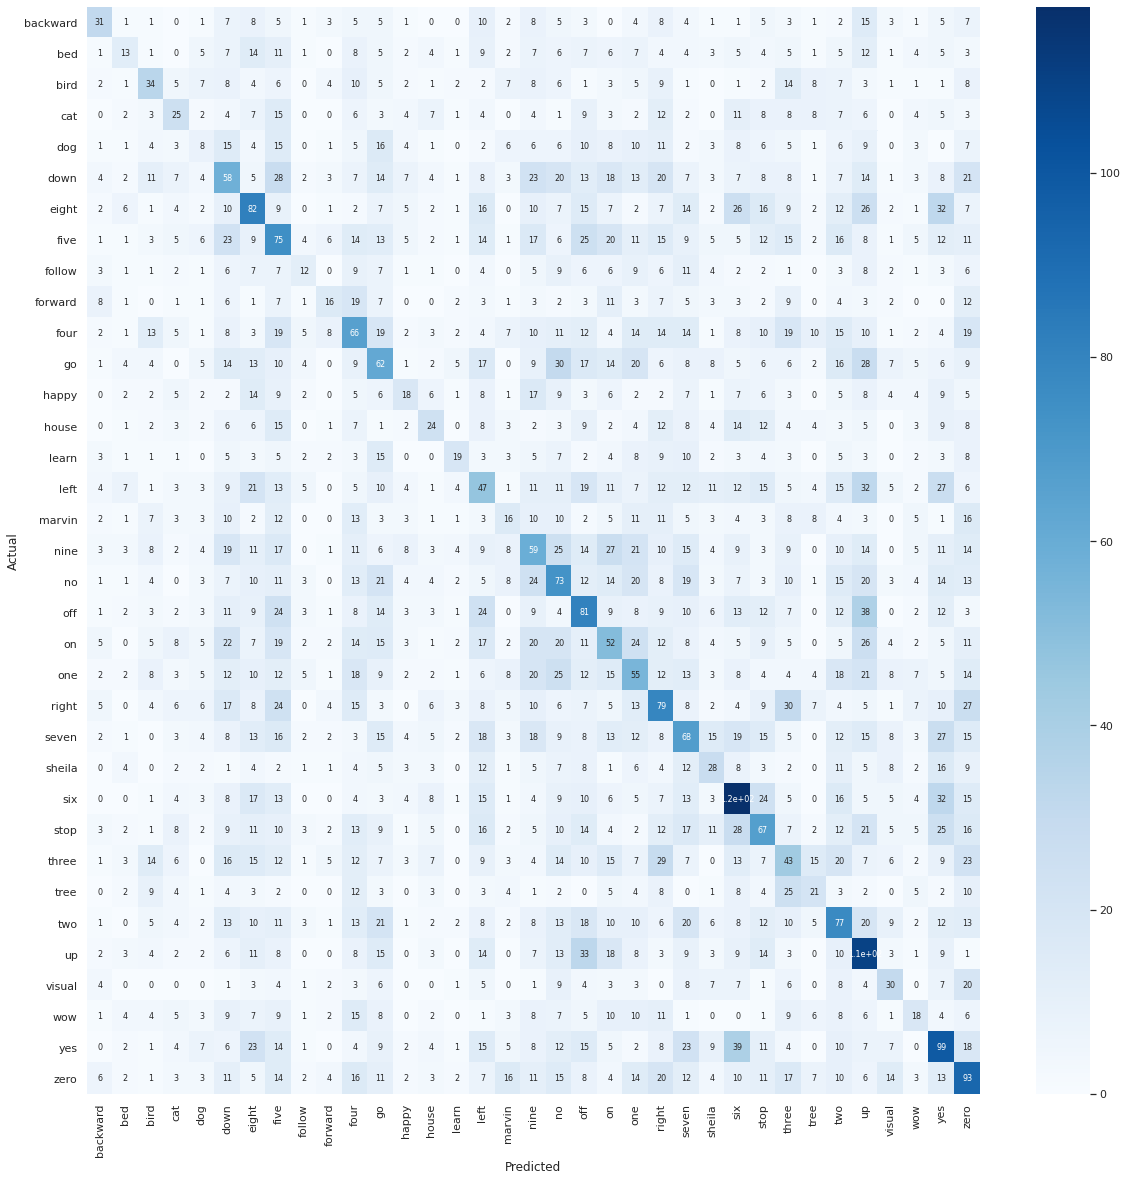

In [ ]:
df_cm = pd.DataFrame(cm, columns=np.unique(y_test_labels), index = np.unique(y_test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,20))
sns.set(font_scale=1)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 8})# font size


---

<a id="approach-2-transfer-learning"></a>
# Approach 2. Transfer Learning

---

# VGGish - Speech Commands - Transfer Learning

**Approach 2: Adding Trainable Layers onto a Frozen VGGish Backbone**

This notebook implements the **transfer learning** approach: we freeze the pre-trained VGGish network (keeping its weights fixed) and add new trainable layers on top. Only the new layers are trained on our Speech Commands data.

**Key idea:** Instead of using VGGish's final 128-dim embedding (which loses too much information, as shown by the 18.4% accuracy in the feature extraction approach), we tap into an earlier, richer layer of the network. Here we connect to the `fc1` layer (a 4096-dim representation before the embedding bottleneck) and add a trainable classification head on top.

**Architecture:**
```
[Frozen VGGish] → fc1 (4096-dim, frozen) → FC layer (500 units, trainable) → Logits (35 classes, trainable) → Softmax
```

**Approach comparison:**
| Approach | VGGish Weights | Accuracy | Training Time |
|----------|---------------|----------|---------------|
| Feature Extraction | Frozen | ~18.4% | 3 min (CPU) |
| **Transfer Learning** (this notebook) | Frozen | ~30.4% | 28 min (GPU) |
| Warm Start | Unfrozen | ~96.6% | 1h 20min (GPU) |

**Result:** ~30.4% accuracy -- better than feature extraction but still poor. Freezing VGGish prevents the convolutional layers from adapting their learned features to the speech command domain.

## Setup and Imports

Import TensorFlow (v1 compatibility mode), TF-Slim for building layers, and the VGGish library. This notebook was run on an AWS EC2 p3.2xlarge instance with a single NVIDIA Tesla V100-SXM2-16GB GPU.

In [ ]:
import sys
sys.path.append("/home/ubuntu/odsc/vggish/lib/models/research/audioset/vggish")

In [ ]:
import pandas as pd


In [ ]:
import vggish_params
vggish_params.EXAMPLE_HOP_SECONDS, vggish_params.EXAMPLE_WINDOW_SECONDS

(0.96, 0.96)

In [ ]:
import numpy as np
import six
import soundfile
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tf_slim as slim

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  1


In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [ ]:

import vggish_input
import vggish_postprocess
import vggish_slim

pca_params = '/home/ubuntu/odsc/vggish/lib/vggish_pca_params.npz'
ckpt = '/home/ubuntu/odsc/vggish/lib/vggish_model.ckpt'

In [ ]:
df = pd.read_csv('wavfile_df.csv', index_col=0)
df.shape

(105835, 3)

## Loading and Preparing Spectrograms

Load the pre-generated spectrograms from Step 1. Invalid spectrograms (from files that were too short/long) are removed, leaving 96,826 valid samples across 35 word classes.

Labels are one-hot encoded for use with the softmax cross-entropy loss function. The data is split 90/10 (train/test) with stratification to preserve class proportions.

In [ ]:
with open('wavfile_spec.dat', 'rb') as f:
    audio_data = np.fromfile(f)

In [ ]:
audio_array = audio_data.reshape((-1, 96, 64))
audio_array.shape, df.shape

((105835, 96, 64), (105835, 3))

In [ ]:
# Drop invalid spectograms
invalid_ind = df[~df['valid']].index

In [ ]:
valid_audio = np.delete(audio_array, invalid_ind, axis=0)
valid_audio.shape

(96826, 96, 64)

In [ ]:
df = df[df.valid]
df.shape

(96826, 3)

In [ ]:
num_classes = len(df.label.unique())
num_classes, df['label'].value_counts()

(35,
 zero        3793
 five        3779
 yes         3743
 seven       3713
 nine        3672
 six         3632
 down        3627
 stop        3602
 no          3599
 two         3579
 left        3550
 one         3542
 go          3528
 on          3522
 right       3483
 off         3473
 eight       3472
 four        3460
 three       3452
 up          3322
 marvin      1884
 house       1872
 dog         1869
 wow         1847
 happy       1811
 sheila      1800
 bird        1792
 cat         1758
 bed         1732
 backward    1567
 tree        1513
 visual      1476
 follow      1463
 forward     1462
 learn       1437
 Name: label, dtype: int64)

In [ ]:
del(audio_data, audio_array)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
all_labels = one_hot_encoder.fit_transform(df.label.to_numpy().reshape(-1, 1)).todense()

In [ ]:
from sklearn.model_selection import train_test_split

audio_train, audio_test, labels_train, labels_test = \
        train_test_split(valid_audio, all_labels, test_size=0.1, stratify=df.label)

In [ ]:
del(all_labels, valid_audio)

### Batching

Split the training data into 500 batches (~174 samples each) for mini-batch gradient descent. This is necessary because the full training set (87,143 spectrograms, each 96x64) would exceed GPU memory if processed at once.

In [ ]:
# audio_train = np.array(audio_train)
# audio_test = np.array(audio_test)
# labels_train = np.array(labels_train)
# labels_test = np.array(labels_test)

In [ ]:
audio_train.shape, audio_test.shape, labels_train.shape, labels_test.shape

((87143, 96, 64), (9683, 96, 64), (87143, 35), (9683, 35))

## Building the Transfer Learning Model

This is the critical section that defines the transfer learning architecture.

**Frozen VGGish backbone:** `define_vggish_slim(training=False)` creates the VGGish network with all weights **frozen** -- gradients will not flow through VGGish during training.

**Custom classification head:** We tap into `vggish/fc1/fc1_2/Relu:0`, the 4096-dimensional output of VGGish's first fully connected layer (before the final compression to 128-dim embeddings). On top of this, we add:

1. **FC layer (500 units)** with ReLU activation -- reduces dimensionality while learning task-specific features
2. **Logits layer (35 units)** with no activation -- one output per word class
3. **Softmax** -- converts logits to class probabilities

**Training configuration:**
- **Loss:** Softmax cross-entropy (standard for single-label multi-class classification)
- **Optimizer:** Adam (same learning rate and epsilon as VGGish's original training)
- **Trainable parameters:** Only the new FC (500) and logits (35) layers -- VGGish's ~62M parameters remain fixed

After defining the model, we initialize all variables, then load the pre-trained VGGish checkpoint to restore its frozen weights.

## Training Loop

Train for 200 epochs, each consisting of 500 mini-batches (100,000 total gradient updates). Each step feeds a batch of spectrograms through the frozen VGGish backbone, then updates only the new classification layers via backpropagation.

Training completed in ~28 minutes on a single Tesla V100 GPU.

In [ ]:
num_batches = 500

## Evaluation

Generate predictions on the test set (processed in 20 batches to manage GPU memory). The model's predicted class is the one with the highest softmax probability for each sample.

In [ ]:
audio_train_batches = np.array_split(audio_train, num_batches, axis=0)
labels_train_batches = np.array_split(labels_train, num_batches, axis=0)

In [ ]:
# sess.close()

In [ ]:
g = tf.Graph()
sess = tf.Session(graph=g)

with g.as_default():
    # Define VGGish.
    embeddings = vggish_slim.define_vggish_slim(training=False)
    
    # Grab last layer of network before compression to embeddings
    vggish_fc1 = sess.graph.get_tensor_by_name('vggish/fc1/fc1_2/Relu:0')
    
    # Define a shallow classification model and associated training ops on top
    # of VGGish.
    with tf.variable_scope('mymodel'):
      # Add fully connected layer with 500 units.
        num_units = 500
        fc1 = slim.fully_connected(vggish_fc1, num_units)

        # Add a classifier layer at the end, consisting of parallel logistic
        # classifiers, one per class. This allows for multi-class tasks.
        logits = slim.fully_connected(
          fc1, num_classes, activation_fn=None, scope='logits')
        
        # Add softmax output layer for classification
        tf.nn.softmax(logits, name='prediction')
        
        prediction_tensor = sess.graph.get_tensor_by_name('mymodel/prediction:0')

      # Add training ops.
        with tf.variable_scope('train'):
            global_step = tf.Variable(
                0, name='global_step', trainable=False,
                collections=[tf.GraphKeys.GLOBAL_VARIABLES,
                             tf.GraphKeys.GLOBAL_STEP])

            # Labels are assumed to be fed as a batch multi-hot vectors, with
            # a 1 in the position of each positive class label, and 0 elsewhere.
            labels = tf.placeholder(
                tf.float32, shape=(None, num_classes), name='labels')

            # Cross-entropy label loss.
            xent = tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=labels, name='xent')
            loss = tf.reduce_mean(xent, name='loss_op')
            tf.summary.scalar('loss', loss)

            # We use the same optimizer and hyperparameters as used to train VGGish.
            optimizer = tf.train.AdamOptimizer(
                learning_rate=vggish_params.LEARNING_RATE,
                epsilon=vggish_params.ADAM_EPSILON)
            optimizer.minimize(loss, global_step=global_step, name='train_op')

with g.as_default():
    # Initialize all variables in the model, and then load the pre-trained
    # VGGish checkpoint.
    sess.run(tf.global_variables_initializer())
    vggish_slim.load_vggish_slim_checkpoint(sess, ckpt)

    # Locate all the tensors and ops we need for the training loop.
    features_tensor = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    labels_tensor = sess.graph.get_tensor_by_name('mymodel/train/labels:0')
    global_step_tensor = sess.graph.get_tensor_by_name(
        'mymodel/train/global_step:0')
    loss_tensor = sess.graph.get_tensor_by_name('mymodel/train/loss_op:0')
    train_op = sess.graph.get_operation_by_name('mymodel/train/train_op')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from /home/ubuntu/odsc/vggish/lib/vggish_model.ckpt


In [ ]:
%%time

# The training loop.
for _ in range(200):
    for i in range(num_batches):
        labels = labels_train_batches[i]
        features = audio_train_batches[i]

        [num_steps, loss, _] = sess.run(
          [global_step_tensor, loss_tensor, train_op],
          feed_dict={features_tensor: features, labels_tensor: labels})
        print('Step %d: loss %g' % (num_steps, loss))


Step 1: loss 3.55874
Step 2: loss 3.55128
Step 3: loss 3.55371
Step 4: loss 3.55708
Step 5: loss 3.54878
... [4,726 lines omitted] ...
Step 99998: loss 1.42592
Step 99999: loss 1.32426
Step 100000: loss 1.17431
CPU times: user 10min 53s, sys: 25 s, total: 11min 18s
Wall time: 28min 27s

In [ ]:
# Above time taken on EC2 - p3.2xlarge - 1 GPU - Tesla V100-SXM2-16GB
# Wall time: 28min 27s


In [ ]:
batches = np.array_split(np.arange(audio_test.shape[0]), 20)

In [ ]:
predictions = np.zeros((audio_test.shape[0], num_classes))

In [ ]:
for b in batches:
    [predictions[b]] = sess.run([prediction_tensor],
                             feed_dict={features_tensor: audio_test[b,:]})


### Results: ~30.4% Accuracy

This is a significant improvement over the feature extraction approach (18.4%) but still far below practical utility.

**Why is transfer learning underperforming?** The frozen VGGish convolutional layers were trained on AudioSet, which contains broad audio categories (music, speech, environmental sounds). The features these layers extract are general-purpose audio features, not specialized for distinguishing between similar-sounding spoken words. Since the convolutional layers are frozen, the model cannot adapt its feature extraction to the specific patterns needed for speech command recognition.

The confusion matrix below shows widespread misclassification across many word pairs, indicating that the frozen features do not provide sufficient discriminative power for this task.

**Lesson:** Transfer learning with frozen features works best when the source and target domains are closely related. AudioSet's broad audio classification is too different from fine-grained speech command recognition for frozen features to be effective.

In [ ]:
predictions.shape

(9683, 35)

In [ ]:
pred_label = one_hot_encoder.inverse_transform(predictions)

In [ ]:
labels_test_label = one_hot_encoder.inverse_transform(labels_test)

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score

In [ ]:
1/35

0.02857142857142857

In [ ]:
accuracy_score(labels_test_label, pred_label)

0.30424455230816894

In [ ]:
cm = confusion_matrix(labels_test_label, pred_label)

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

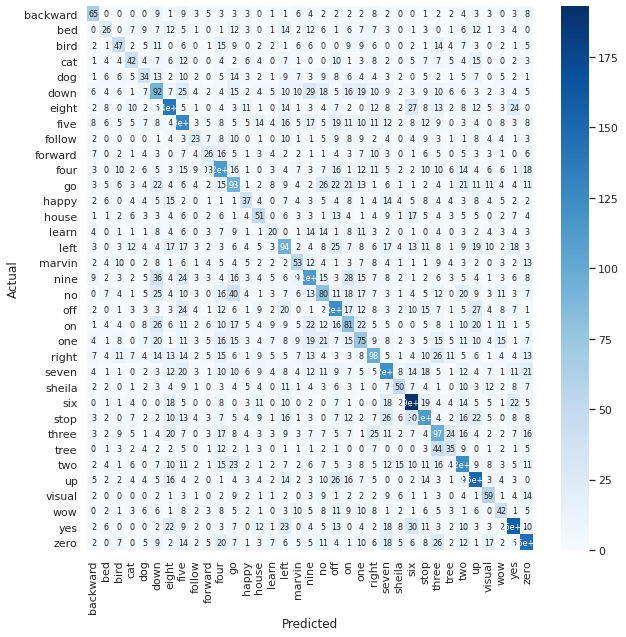

In [ ]:
df_cm = pd.DataFrame(cm, columns=np.unique(labels_test_label), index = np.unique(labels_test_label))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 8})# font size


In [ ]:
sess.close()

---

<a id="approach-3-warm-start"></a>
# Approach 3. Warm Start

---

# VGGish - Speech Commands - Warm Start

**Approach 3: Fine-Tuning the Entire Network (End-to-End Training)**

This notebook implements the **warm start** (fine-tuning) approach: we load the pre-trained VGGish weights as initialization but make the **entire network trainable**, allowing all layers -- including VGGish's convolutional backbone -- to adapt to our speech command data.

**Key difference from transfer learning:** The single change is `define_vggish_slim(training=True)` instead of `training=False`. This unfreezes all VGGish weights, enabling end-to-end backpropagation through the full network.

**Architecture (identical to transfer learning):**
```
[Trainable VGGish] → fc1 (4096-dim, trainable) → FC layer (500 units, trainable) → Logits (35 classes, trainable) → Softmax
```

**Approach comparison:**
| Approach | VGGish Weights | Accuracy | Training Time |
|----------|---------------|----------|---------------|
| Feature Extraction | Frozen | ~18.4% | 3 min (CPU) |
| Transfer Learning | Frozen | ~30.4% | 28 min (GPU) |
| **Warm Start** (this notebook) | **Unfrozen (fine-tuned)** | **~96.6%** | 1h 20min (GPU) |

**Result:** ~96.6% accuracy -- a dramatic improvement. By allowing the convolutional layers to adapt their learned features from general audio events to speech-specific patterns, the network achieves near-human performance on this task. The pre-trained weights provide an excellent initialization, enabling faster convergence and better final accuracy than training from scratch.

## Setup and Imports

Import TensorFlow (v1 compatibility mode), TF-Slim for building layers, and the VGGish library. This notebook was run on an AWS EC2 p3.2xlarge instance with a single NVIDIA Tesla V100-SXM2-16GB GPU.

In [ ]:
import sys
sys.path.append("/home/ubuntu/odsc/vggish/lib/models/research/audioset/vggish")

In [ ]:
import pandas as pd


In [ ]:
import vggish_params
vggish_params.EXAMPLE_HOP_SECONDS, vggish_params.EXAMPLE_WINDOW_SECONDS

(0.96, 0.96)

In [ ]:
import numpy as np
import six
import soundfile
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tf_slim as slim

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  1


In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [ ]:

import vggish_input
import vggish_postprocess
import vggish_slim

pca_params = '/home/ubuntu/odsc/vggish/lib/vggish_pca_params.npz'
ckpt = '/home/ubuntu/odsc/vggish/lib/vggish_model.ckpt'

In [ ]:
df = pd.read_csv('wavfile_df.csv', index_col=0)
df.shape

(105835, 3)

## Loading and Preparing Spectrograms

Load the pre-generated spectrograms from Step 1. After removing invalid entries, we have 96,826 valid samples across 35 word classes. Labels are one-hot encoded, and data is split 90/10 (train/test) with stratification.

In [ ]:
with open('wavfile_spec.dat', 'rb') as f:
    audio_data = np.fromfile(f)

In [ ]:
audio_array = audio_data.reshape((-1, 96, 64))
audio_array.shape, df.shape

((105835, 96, 64), (105835, 3))

In [ ]:
# Drop invalid spectograms
invalid_ind = df[~df['valid']].index

In [ ]:
valid_audio = np.delete(audio_array, invalid_ind, axis=0)
valid_audio.shape

(96826, 96, 64)

In [ ]:
df = df[df.valid]
df.shape

(96826, 3)

In [ ]:
num_classes = len(df.label.unique())
num_classes, df['label'].value_counts()

(35,
 zero        3793
 five        3779
 yes         3743
 seven       3713
 nine        3672
 six         3632
 down        3627
 stop        3602
 no          3599
 two         3579
 left        3550
 one         3542
 go          3528
 on          3522
 right       3483
 off         3473
 eight       3472
 four        3460
 three       3452
 up          3322
 marvin      1884
 house       1872
 dog         1869
 wow         1847
 happy       1811
 sheila      1800
 bird        1792
 cat         1758
 bed         1732
 backward    1567
 tree        1513
 visual      1476
 follow      1463
 forward     1462
 learn       1437
 Name: label, dtype: int64)

In [ ]:
del(audio_data, audio_array)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
all_labels = one_hot_encoder.fit_transform(df.label.to_numpy().reshape(-1, 1)).todense()

In [ ]:
from sklearn.model_selection import train_test_split

audio_train, audio_test, labels_train, labels_test = \
        train_test_split(valid_audio, all_labels, test_size=0.1, stratify=df.label)

In [ ]:
del(all_labels, valid_audio)

### Batching

Split the training data into 500 batches (~174 samples each) for mini-batch gradient descent.

In [ ]:
audio_train.shape, audio_test.shape, labels_train.shape, labels_test.shape

((87143, 96, 64), (9683, 96, 64), (87143, 35), (9683, 35))

## Building the Warm Start Model

This section is nearly identical to the transfer learning notebook, with one crucial difference:

**`define_vggish_slim(training=True)`** -- This makes **all** VGGish weights trainable. During backpropagation, gradients flow through the entire network, allowing the convolutional filters to adapt from general audio features to speech-specific features.

**What "warm start" means:** Instead of initializing all weights randomly (cold start) or freezing pre-trained weights (transfer learning), we initialize with the pre-trained AudioSet weights and then **continue training** (fine-tuning) all of them on our task-specific data. The pre-trained weights serve as a warm starting point, giving the optimizer a head start compared to random initialization.

**Architecture (same as transfer learning):**
1. VGGish convolutional backbone → fc1 (4096-dim) -- **now trainable**
2. New FC layer (500 units, ReLU) -- trainable
3. New logits layer (35 units) -- trainable
4. Softmax output

**Training configuration:** Same Adam optimizer, learning rate, and loss function as the transfer learning notebook. The only difference is the number of trainable parameters -- the warm start model trains ~62M+ parameters (the entire VGGish network plus the new layers), compared to just the new layers in transfer learning.

## Training Loop

Train for 200 epochs x 500 batches (100,000 total gradient updates) -- the same training schedule as transfer learning. However, since gradients now flow through the entire network, each step takes longer.

Training completed in ~1 hour 20 minutes on a single Tesla V100 GPU (vs. 28 minutes for transfer learning). The additional compute cost is due to backpropagating through VGGish's deep convolutional stack.

In [ ]:
num_batches = 500

## Evaluation

Generate predictions on the test set (processed in 20 batches to manage GPU memory).

In [ ]:
audio_train_batches = np.array_split(audio_train, num_batches, axis=0)
labels_train_batches = np.array_split(labels_train, num_batches, axis=0)

In [ ]:
# sess.close()

In [ ]:
g = tf.Graph()
sess = tf.Session(graph=g)

with g.as_default():
    # Define VGGish.
    embeddings = vggish_slim.define_vggish_slim(training=True)
   
    # Grab last layer of network before compression to embeddings
    vggish_fc1 = sess.graph.get_tensor_by_name('vggish/fc1/fc1_2/Relu:0')
    
    # Define a shallow classification model and associated training ops on top
    # of VGGish.
    with tf.variable_scope('mymodel'):
      # Add fully connected layer with 500 units.
        num_units = 500
        fc1 = slim.fully_connected(vggish_fc1, num_units)

        # Add a classifier layer at the end, consisting of parallel logistic
        # classifiers, one per class. This allows for multi-class tasks.
        logits = slim.fully_connected(
          fc1, num_classes, activation_fn=None, scope='logits')
        
        # Add softmax output layer for classification
        tf.nn.softmax(logits, name='prediction')
        
        prediction_tensor = sess.graph.get_tensor_by_name('mymodel/prediction:0')

      # Add training ops.
        with tf.variable_scope('train'):
            global_step = tf.Variable(
                0, name='global_step', trainable=False,
                collections=[tf.GraphKeys.GLOBAL_VARIABLES,
                             tf.GraphKeys.GLOBAL_STEP])

            # Labels are assumed to be fed as a batch multi-hot vectors, with
            # a 1 in the position of each positive class label, and 0 elsewhere.
            labels = tf.placeholder(
                tf.float32, shape=(None, num_classes), name='labels')

            # Cross-entropy label loss.
            xent = tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=labels, name='xent')
            loss = tf.reduce_mean(xent, name='loss_op')
            tf.summary.scalar('loss', loss)

            # We use the same optimizer and hyperparameters as used to train VGGish.
            optimizer = tf.train.AdamOptimizer(
                learning_rate=vggish_params.LEARNING_RATE,
                epsilon=vggish_params.ADAM_EPSILON)
            optimizer.minimize(loss, global_step=global_step, name='train_op')

    # Initialize all variables in the model, and then load the pre-trained
    # VGGish checkpoint.
    sess.run(tf.global_variables_initializer())
    vggish_slim.load_vggish_slim_checkpoint(sess, ckpt)

    # Locate all the tensors and ops we need for the training loop.
    features_tensor = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    labels_tensor = sess.graph.get_tensor_by_name('mymodel/train/labels:0')
    global_step_tensor = sess.graph.get_tensor_by_name(
        'mymodel/train/global_step:0')
    loss_tensor = sess.graph.get_tensor_by_name('mymodel/train/loss_op:0')
    train_op = sess.graph.get_operation_by_name('mymodel/train/train_op')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from /home/ubuntu/odsc/vggish/lib/vggish_model.ckpt


In [ ]:
%%time

# The training loop.
for _ in range(200):
    for i in range(num_batches):
        labels = labels_train_batches[i]
        features = audio_train_batches[i]

        [num_steps, loss, _] = sess.run(
          [global_step_tensor, loss_tensor, train_op],
          feed_dict={features_tensor: features, labels_tensor: labels})
        print('Step %d: loss %g' % (num_steps, loss))


Step 1: loss 3.55472
Step 2: loss 3.56273
Step 3: loss 3.56163
Step 4: loss 3.55823
Step 5: loss 3.5586
... [5,510 lines omitted] ...
Step 99998: loss 7.22766e-07
Step 99999: loss 1.52094e-07
Step 100000: loss 1.45928e-07
CPU times: user 50min 25s, sys: 14min 10s, total: 1h 4min 36s
Wall time: 1h 19min 30s

In [ ]:
# Above time taken on EC2 - p3.2xlarge - 1 GPU - Tesla V100-SXM2-16GB
# Wall time: Wall time: 1h 19min 20s



In [ ]:
batches = np.array_split(np.arange(audio_test.shape[0]), 20)
predictions = np.zeros((audio_test.shape[0], num_classes))

In [ ]:
for b in batches:
    [predictions[b]] = sess.run([prediction_tensor],
                             feed_dict={features_tensor: audio_test[b,:]})


### Results: ~96.6% Accuracy

A dramatic improvement from 30.4% (transfer learning) to 96.6% (warm start) -- achieved by changing a single parameter (`training=True` vs `training=False`).

**Why does this work so well?**

1. **Feature adaptation:** The convolutional layers can now refine their filters from general audio features (learned on AudioSet) to speech-specific features. Early layers may learn better phoneme detectors, while deeper layers may learn word-level patterns.

2. **Pre-trained initialization advantage:** Starting from pre-trained weights rather than random initialization means the network already "knows" general audio concepts (frequency patterns, temporal dynamics, spectral shapes). Fine-tuning adapts this knowledge rather than learning from scratch, requiring fewer training examples and fewer epochs.

3. **End-to-end optimization:** Every layer is optimized jointly for the final classification objective, ensuring that features extracted at every level are maximally useful for distinguishing between speech commands.

**The trade-off:** Warm start takes ~3x longer to train than transfer learning (1h 20min vs 28min) because gradients must be computed through the full network. But the accuracy improvement (30% → 97%) makes this an easy choice.

The confusion matrix below shows that most words are classified with high accuracy, with only occasional confusions between phonetically similar words.

In [ ]:
predictions.shape

(9683, 35)

In [ ]:
pred_label = one_hot_encoder.inverse_transform(predictions)

In [ ]:
labels_test_label = one_hot_encoder.inverse_transform(labels_test)

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score

In [ ]:
1/35

0.02857142857142857

In [ ]:
accuracy_score(labels_test_label, pred_label)

0.966229474336466

In [ ]:
cm = confusion_matrix(labels_test_label, pred_label)

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

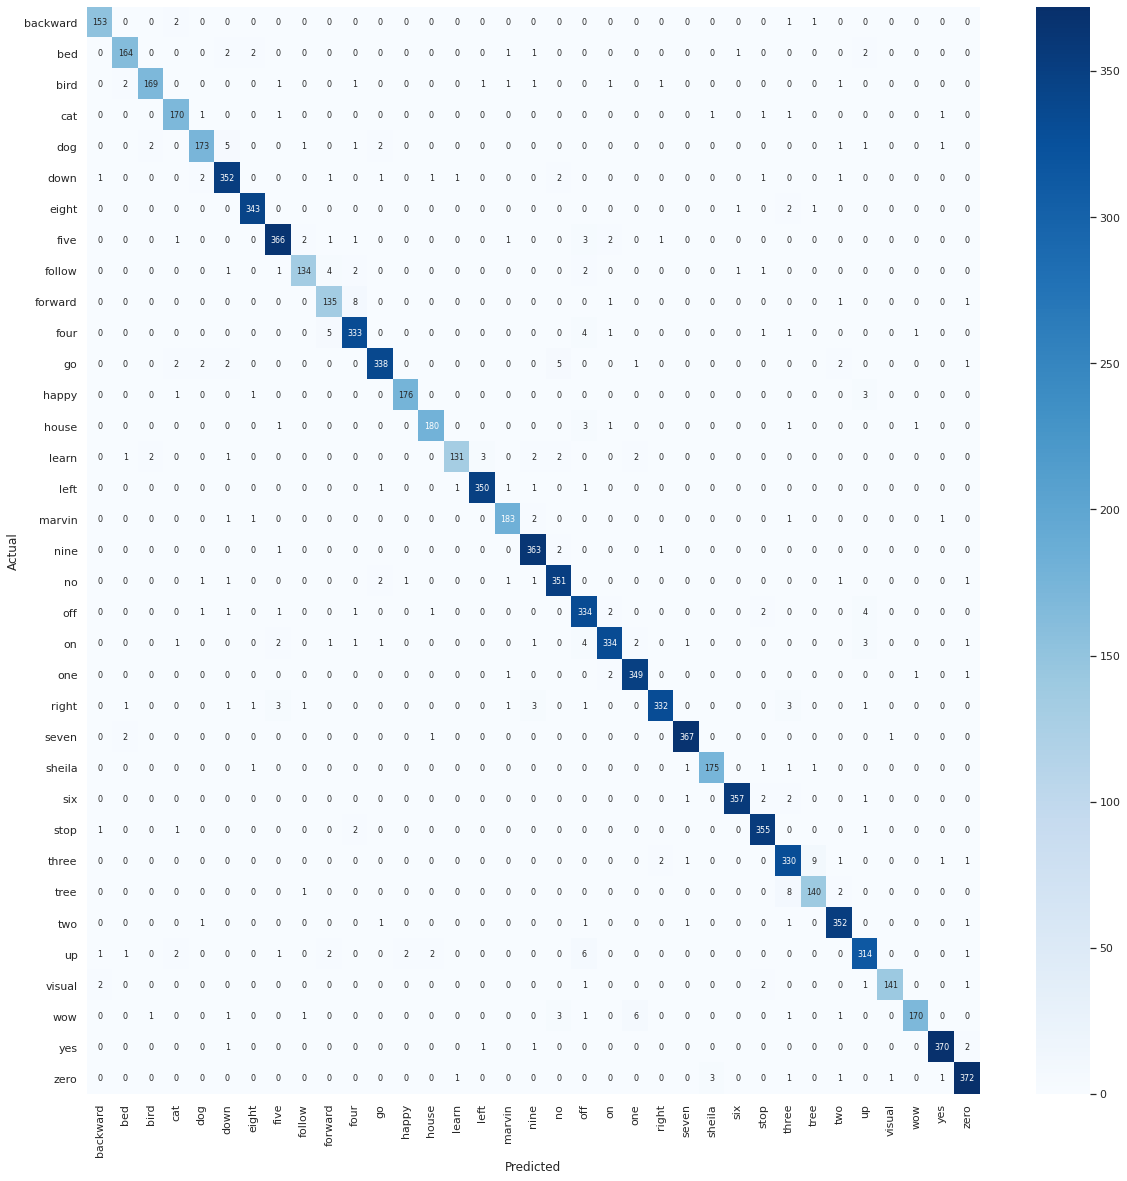

In [ ]:
df_cm = pd.DataFrame(cm, columns=np.unique(labels_test_label), index = np.unique(labels_test_label))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,20))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='g',annot_kws={"size": 8})# font size


In [ ]:
sess.close()

---

# Conclusion

This notebook demonstrated the complete pipeline for audio classification using VGGish and the Speech Commands dataset. The key findings are:

1. **Feature Extraction (~18.4%)**: Using VGGish embeddings as fixed features with a traditional ML classifier (XGBoost) performs poorly because the 128-dim embedding bottleneck loses task-specific information.

2. **Transfer Learning (~30.4%)**: Freezing VGGish and training only new classification layers improves accuracy, but the frozen convolutional features cannot adapt to speech-specific patterns.

3. **Warm Start (~96.6%)**: Fine-tuning the entire network achieves excellent accuracy by allowing all layers to adapt from general audio features to speech command recognition.

**Practical Implications:**
- For tasks similar to the pre-training domain, frozen features may suffice
- For domain-specific tasks, fine-tuning is often necessary
- Pre-trained weights provide a valuable initialization, even when fine-tuning
- The trade-off between training time (3x longer for warm start) and accuracy (~3x better) strongly favors fine-tuning in this case